In [430]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing
import re
import cantera as ct

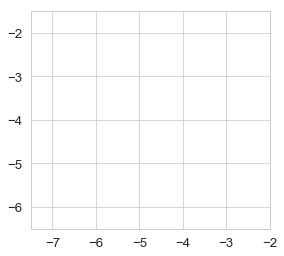

array([[[-7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   ,
         -7.5   , -7.5   ],
        [-6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125,
         -6.8125, -6.8125],
        [-6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 ,
         -6.125 , -6.125 ],
        [-5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375,
         -5.4375, -5.4375],
        [-4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  ,
         -4.75  , -4.75  ],
        [-4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625,
         -4.0625, -4.0625],
        [-3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 ,
         -3.375 , -3.375 ],
        [-2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875,
         -2.6875, -2.6875],
        [-2.    , -2.    , -2.    , -2.    , -2.    , -2.    , -2.    ,
         -2.    , -2.    ]],

       [[-6.5   , -5.875 , -5.25  , -4.625 , -4.    , -3.375 , -2.75  ,
         -2.125 , -1.5   ]

In [3]:
carbon_range = (-7.5, -2)
oxygen_range = (-6.5, -1.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, 
                 oxygen_range[0]:oxygen_range[1]:grid_size*1j]

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
plt.show()
    
mesh

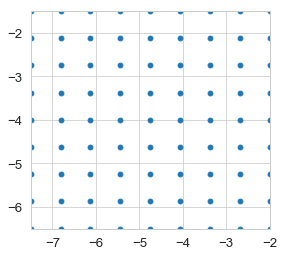

In [4]:
experiments = mesh.reshape((2,-1)).T

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.plot(*experiments.T, marker='o', linestyle='none')

In [441]:
extent = carbon_range + oxygen_range

# Because the center of a corner pixel is in fact the corner of the grid# Becaus 
# we want to stretch the image a little
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2

In [632]:
def calculate(data):
    ratio = data[1]
    ch4_in = data[2]
    ch4_out = data[3]
    co_out = data[4]
    h2_out = data[5]
    h2o_out = data[6]
    co2_out = data[7]
    exit_T = data[8]
    max_T = data[9]
    dist_Tmax = data[10]  # currently is 70 if nothing happens, might want to make it blank
    
    ch4_depletion = ch4_in - ch4_out
    if ch4_depletion <= 1e-8:  # basically nothing happened, so put placeholder 0s in
        ch4_conv = 0.
        h2_sel = 0.
        h2_yield = 0.
        co_sel = 0.
        co_yield = 0.
        syngas_sel = 0.
        syngas_yield = 0.
        co2_sel = 0.
        h2o_sel = 0.
        fullox_sel = 0.
        fullox_yield = 0.
        
        return syngas_sel, syngas_yield, co_sel, co_yield, h2_sel, h2_yield, ch4_conv, fullox_sel, fullox_yield, exit_T, max_T, dist_Tmax
        
    ch4_conv = ch4_depletion / ch4_in
    h2_sel = h2_out / (ch4_depletion * 2)
    h2_yield = h2_out / ( ch4_in * 2)
    co_sel = co_out / ch4_depletion
    co_yield = co_out / ch4_in
    syngas_sel = co_sel + h2_sel
    syngas_yield = syngas_sel * ch4_conv
    co2_sel = co2_out / ch4_depletion
    h2o_sel = h2o_out / (2 * ch4_depletion)
    fullox_sel = h2o_sel + co2_sel
    fullox_yield = fullox_sel * ch4_conv
    
    return syngas_sel, syngas_yield, co_sel, co_yield, h2_sel, h2_yield, ch4_conv, fullox_sel, fullox_yield, exit_T, max_T, dist_Tmax
    
def import_data(ratio, file_location=False):
    """
    This imports dict_conversions_celectivities from the original simulation
    """
    if file_location is False:
        data = pd.read_csv('./dict_conversions_selectivities.csv')
    else:
        data = pd.read_csv('./linearscaling/' + file_location + '/dict_conversions_selectivities.csv')
    
    data = data.get_values()
    for x in range(len(data)):
        r = round(data[x][1],1)
        if r == ratio:
            return calculate(data[x])


# For close packed surfaces from
# Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.; Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. Scaling Properties of Adsorption Energies for Hydrogen-Containing Molecules on Transition-Metal Surfaces. Phys. Rev. Lett. 2007, 99 (1), 016105 DOI: 10.1103/PhysRevLett.99.016105.
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
'Ag': ( -2.9545454545454533, -2.9282552993244817),
'Au': ( -3.7499999999999973, -2.302236198462614),
}


def lavaPlot(overall_rate, title, axis=False, folder=False):
    """
    overall rate data to plot
    title is a string for what definition is used
    to normalize colors across many plots, False doesn't normalize axes 
    folder specifies where to save the images
    """
#     df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
#     print df
#     for c, o, t in zip(c_s, o_s, overall_rate):
#         df[c][o] = t
#     a = []
#     for i in df.values: 
#         a = a + list(i)

    overall_rate = np.array(overall_rate)
#     rates = 1./np.array(a)
    rates = overall_rate

    rates_grid = np.reshape(rates, (grid_size,grid_size))
    for i in range(0,8):  # transpose by second diagnol
        for j in range(0, 8 - i):
            rates_grid[i][j], rates_grid[8 - j][8 - i] = rates_grid[8 - j][8 - i], rates_grid[i][j]
    if axis is False:  # no normalizing
        plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r",)
    else:
        plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r", 
                   vmin=axis[0], vmax=axis[1],)
    for metal, coords in abildpedersen_energies.iteritems():
        color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
        plt.plot(coords[0], coords[1], 'o'+color)
        plt.text(coords[0], coords[1], metal, color=color)
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.xlabel('$\Delta E^C$ (eV)')
    plt.ylabel('$\Delta E^O$ (eV)')
    plt.title(str(title))
    plt.colorbar()
    out_dir = 'lsr'
    os.path.exists(out_dir) or os.makedirs(out_dir)
    if folder is False:
        plt.savefig(out_dir + '/' + str(title) +'.png', bbox_inches='tight')
    else:
        plt.savefig(out_dir + '/' + str(folder) + '/' + str(title) +'.png', bbox_inches='tight')
    plt.show()  # comment out to save fig
    plt.clf()

In [633]:
array = os.listdir('./linearscaling/')
array = sorted(array)

# for plotting
c_s = []
o_s = []
for x in array:
    _, c, o = x.split("-")
    c = c[:-1]
    c = -1 *float(c)
    o = -1* float(o)
    c_s.append(c)
    o_s.append(o)

ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
sens_types = ['SynGas Selectivity', 'SynGas Yield', 'CO Selectivity', 'CO Yield',
              'H2 Selectivity', 'H2 Yield', 'CH4 Conversion', 'CO2+H2O Selectivity',
              'CO2+H2O Yield', 'Exit Temperature', 'Maximum Temperature', 
              'Dist to Max Temperature']
all_data = []
for ratio in ratios:
    ans = []
    for f in array:
        ans.append(import_data(ratio, file_location=f))
    all_data.append(ans)

#     for s in range(len(ans[0])):  # plot each original sens value
#         data_to_plot = []
#         for x in range(len(ans)):
#             data_to_plot.append(ans[x][s])
#         title = str(ratio) + ' ' + sens_types[s]
#         lavaPlot(data_to_plot, title)  # making plots
    
    
# to normalize colors across ratios
spans = []
for m in range(len(all_data[0][0])):  # for each sens definition
    all_sens_data = []
    for x in range(len(all_data)):  # for each ratio
        for y in range(len(all_data[0])):
            # x has len 15 and is each of the ratios
            # y has len 81 and is each of the lsr binding energies
            # the last number is the type of sensitivity definition and is 0-12
            all_sens_data.append(all_data[x][y][m])
    vmax = max(all_sens_data)
    vmin = min(all_sens_data)
#     print all_sens_data
    spans.append([vmin, vmax])
    print sens_types[m], vmin, vmax

SynGas Selectivity 0.0 2.000000739808941
SynGas Yield 0.0 1.4959571543095207
CO Selectivity 0.0 1.0000003666801673
CO Yield 0.0 0.818959937926673
H2 Selectivity 0.0 1.0000022862523807
H2 Yield 0.0 0.7059125609087754
CH4 Conversion 0.0 0.9841785006479921
CO2+H2O Selectivity 0.0 1.9993558570655767
CO2+H2O Yield 0.0 0.5323000617670208
Exit Temperature 699.994447005 1883.05018961
Maximum Temperature 700.0 1932.60356299
Dist to Max Temperature 0.02 70.0


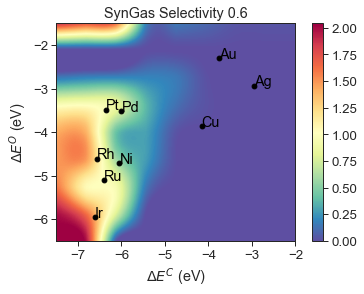

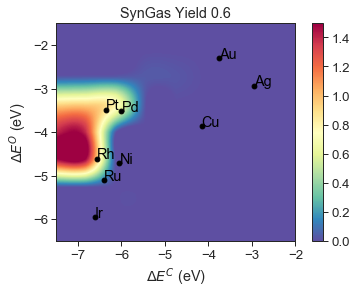

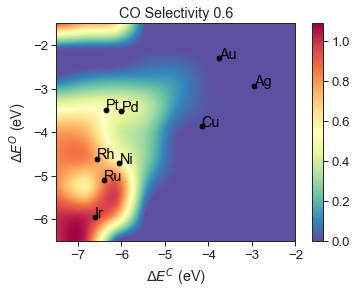

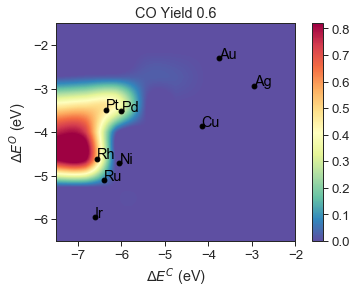

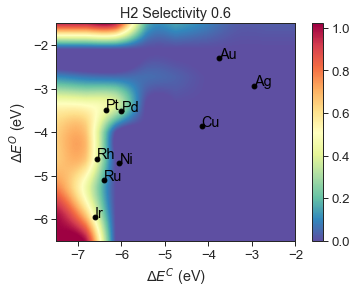

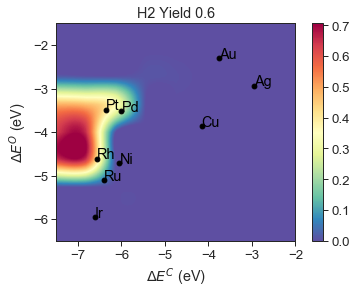

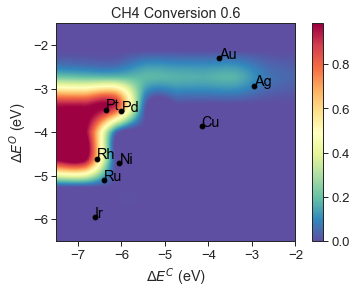

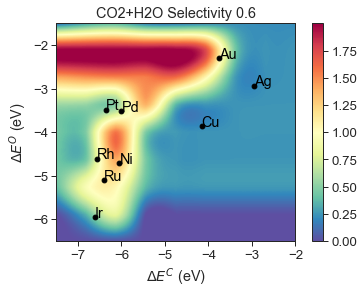

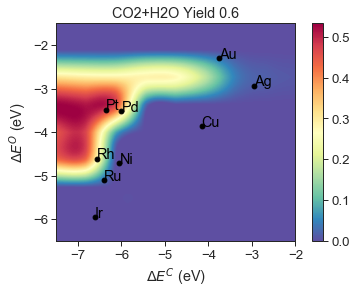

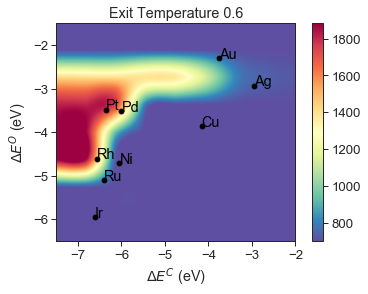

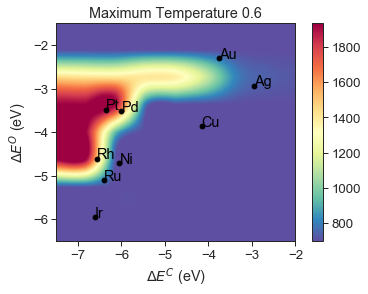

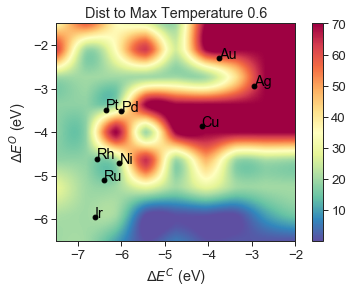

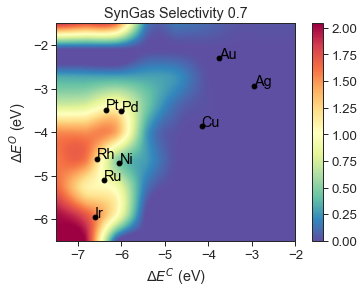

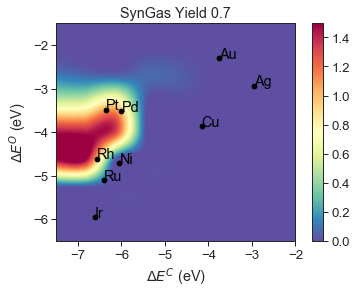

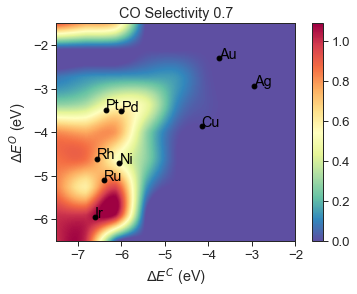

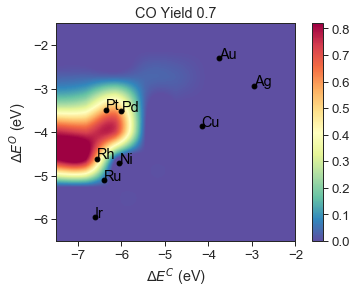

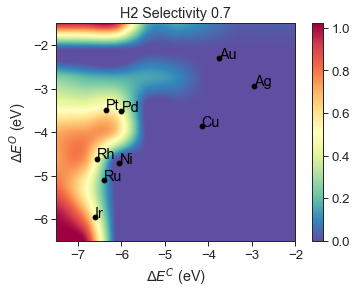

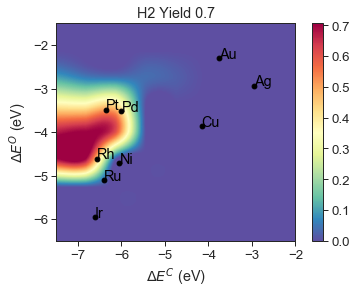

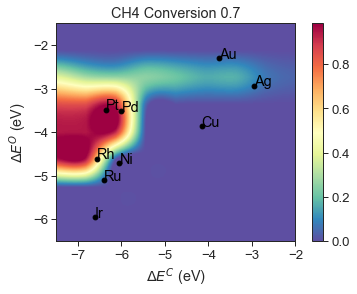

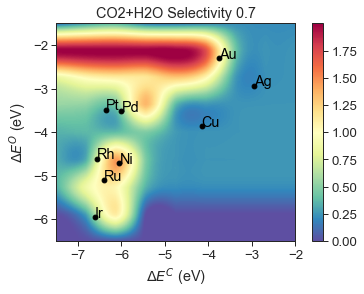

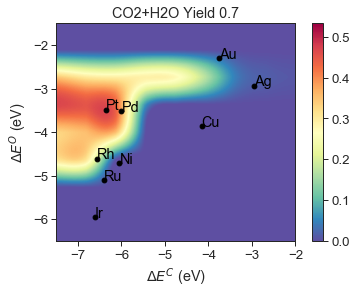

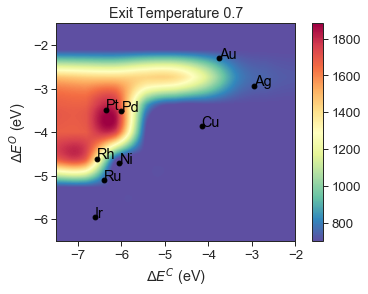

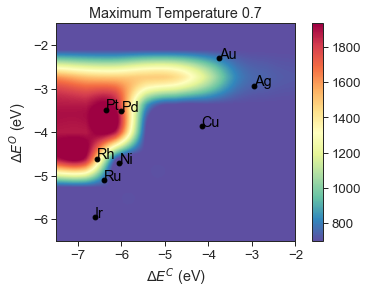

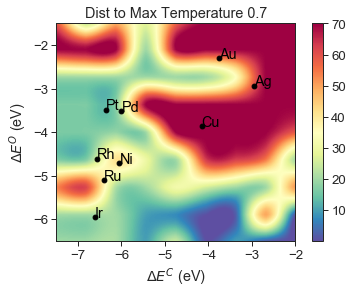

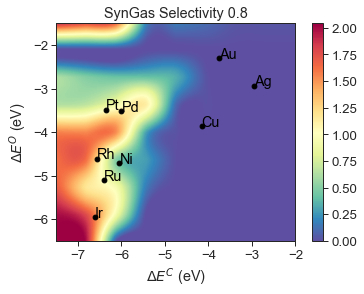

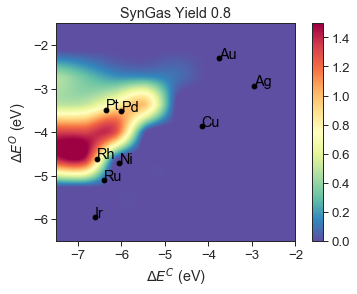

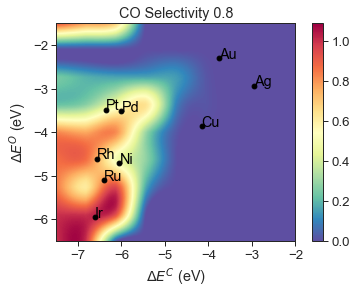

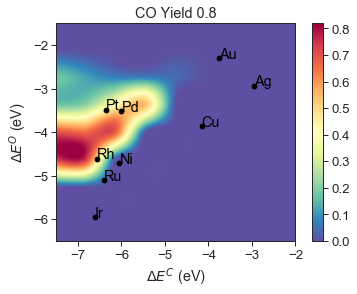

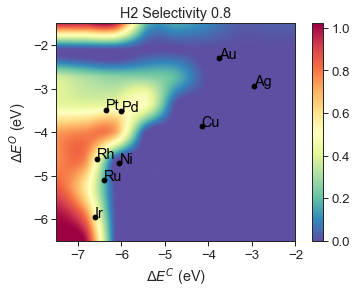

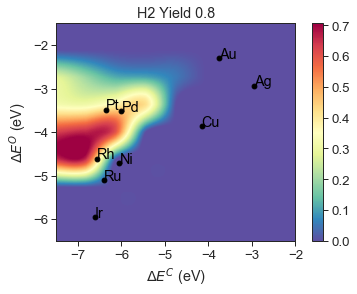

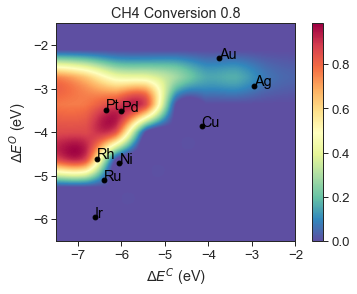

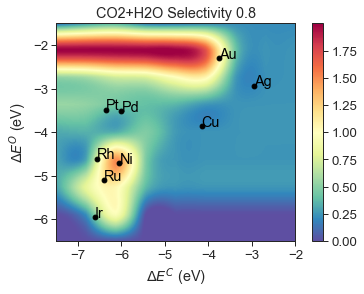

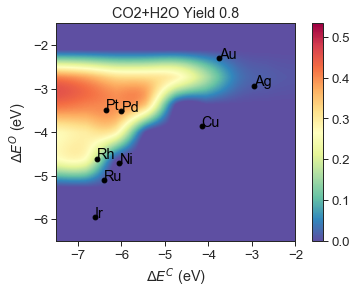

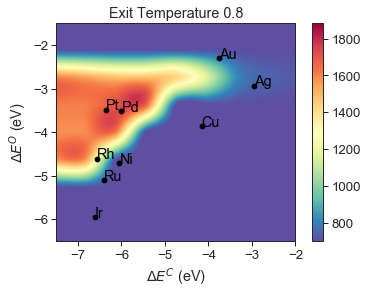

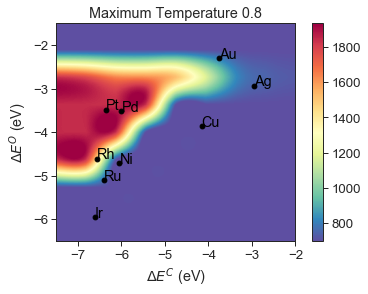

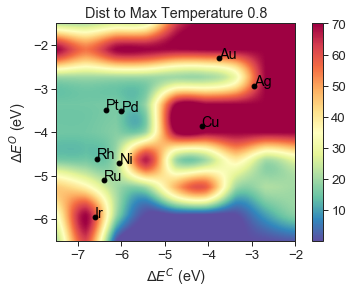

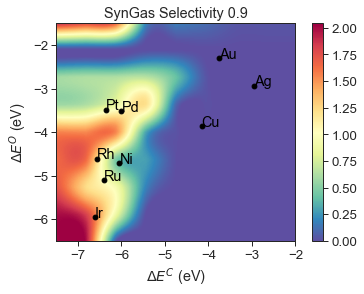

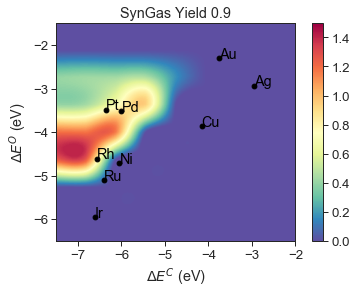

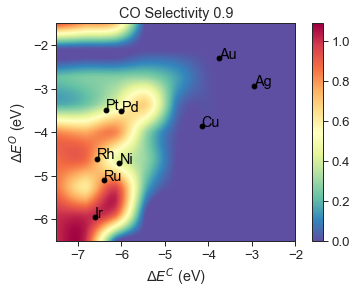

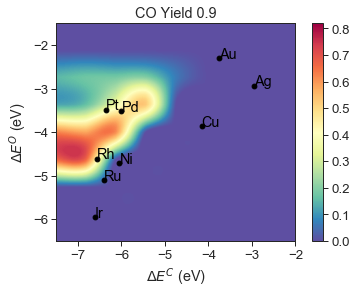

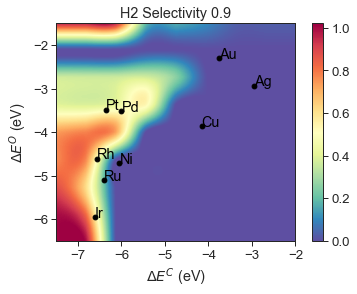

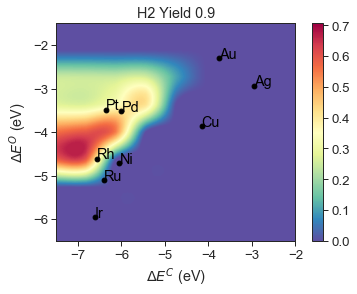

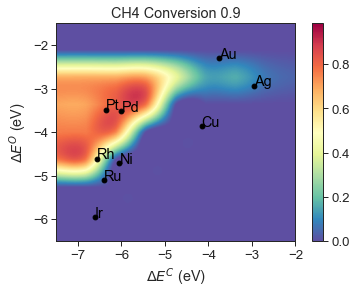

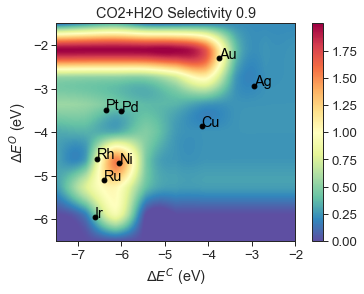

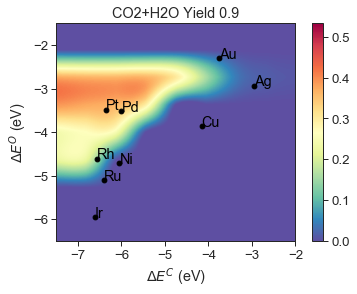

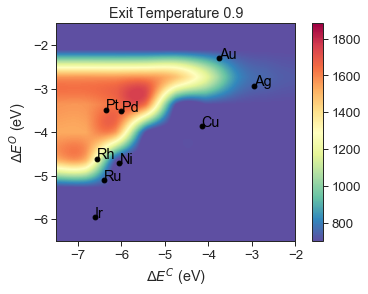

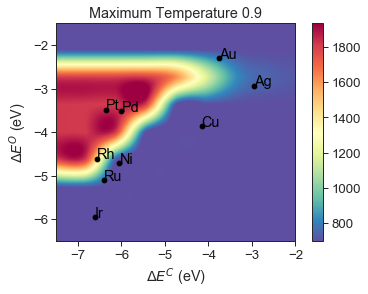

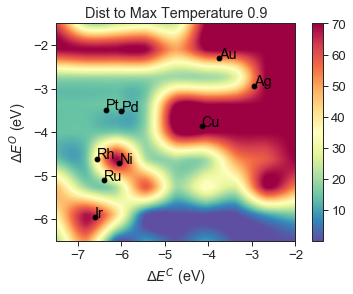

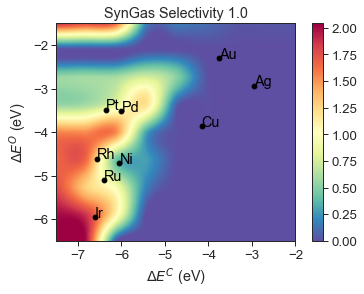

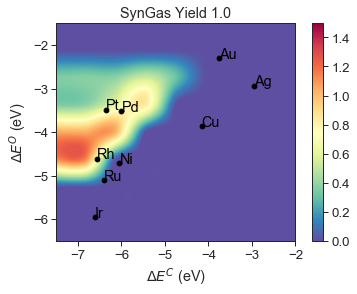

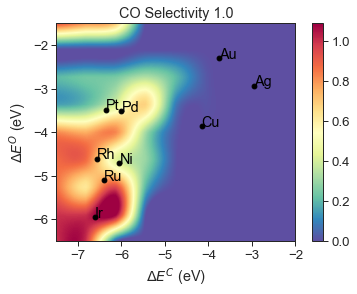

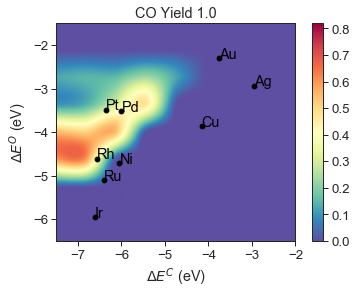

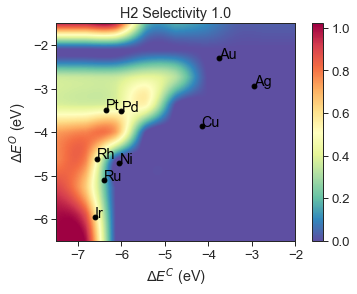

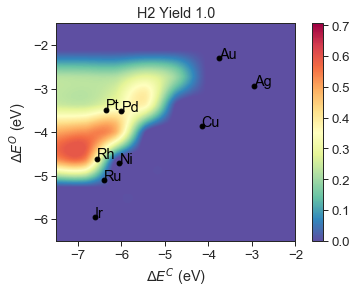

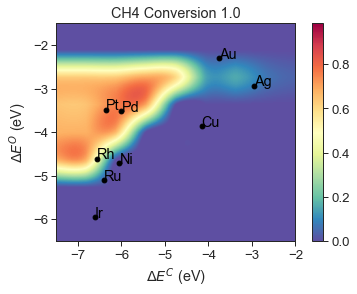

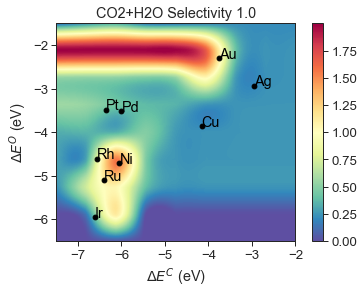

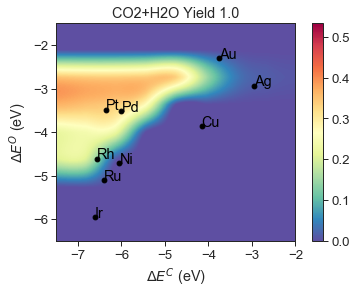

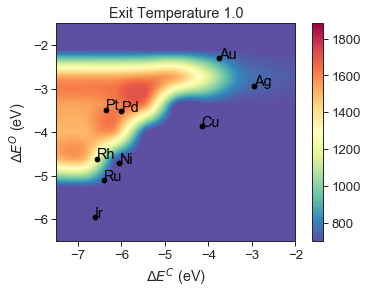

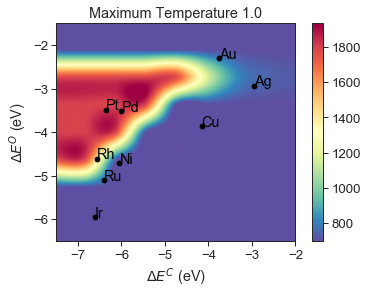

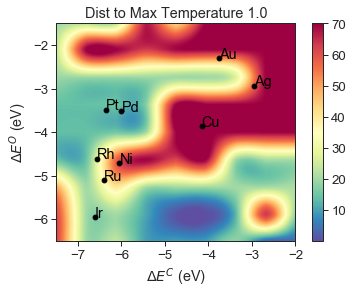

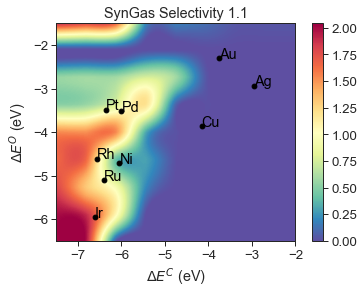

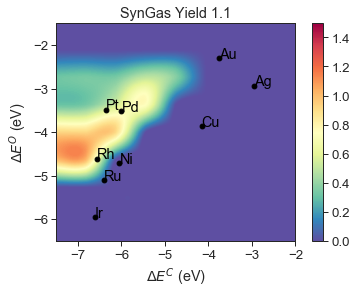

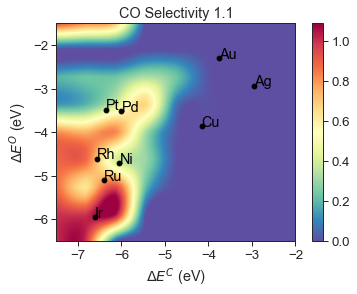

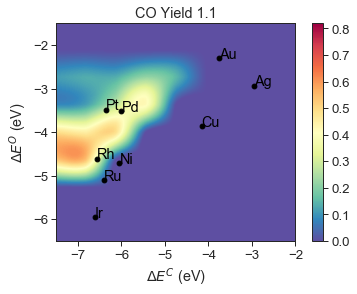

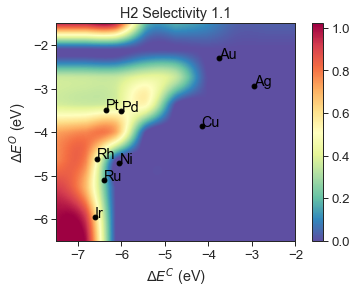

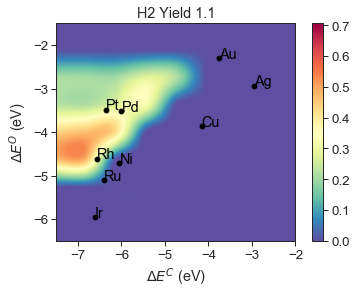

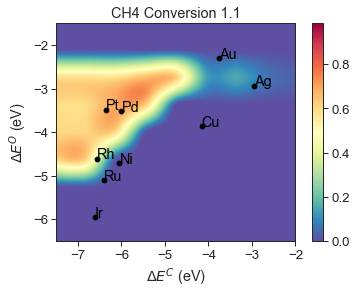

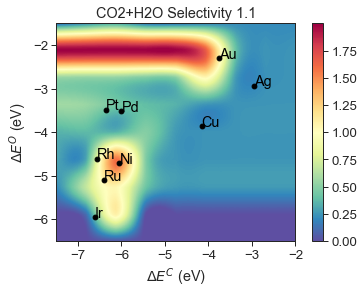

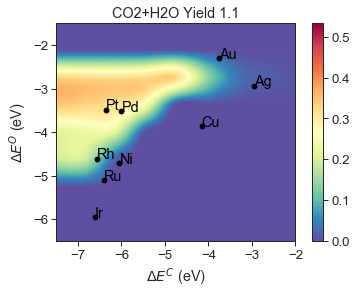

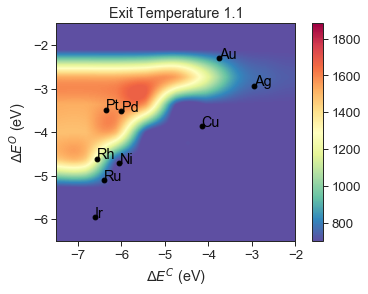

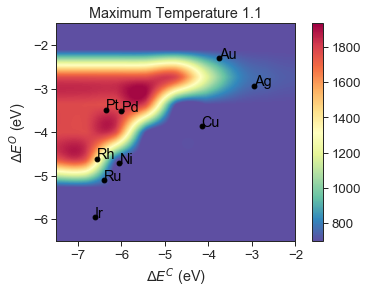

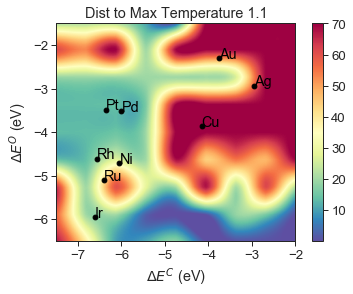

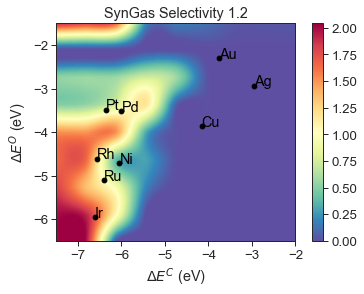

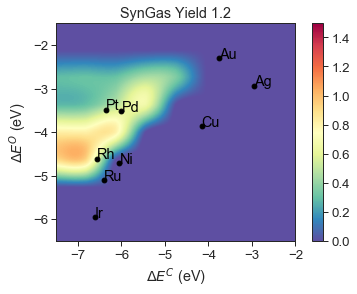

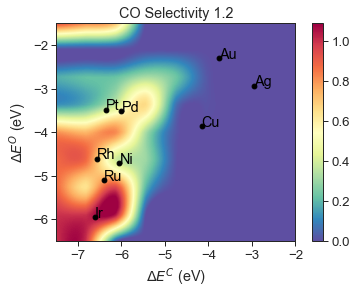

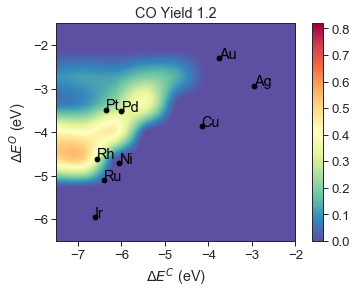

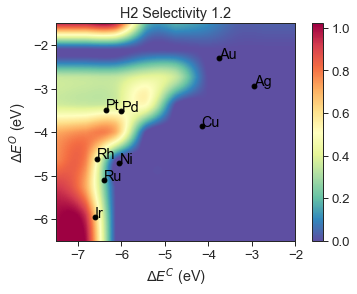

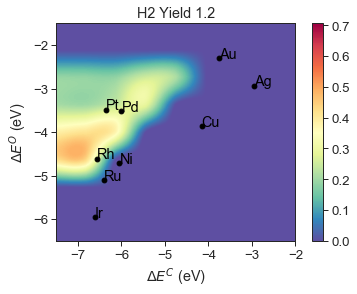

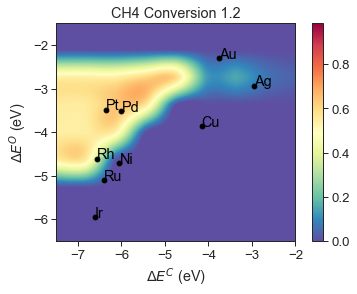

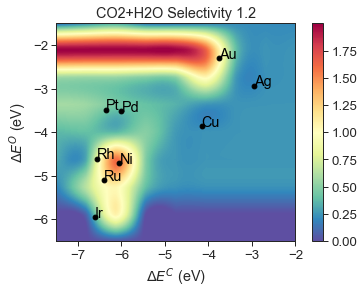

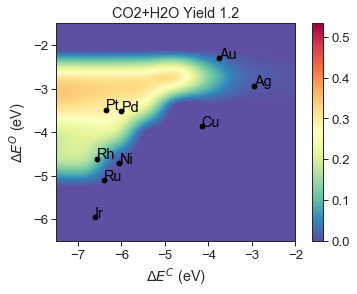

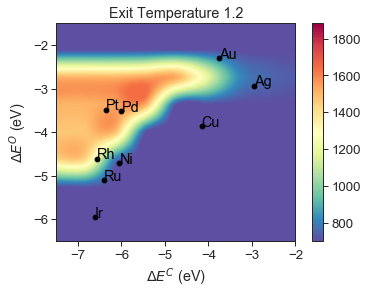

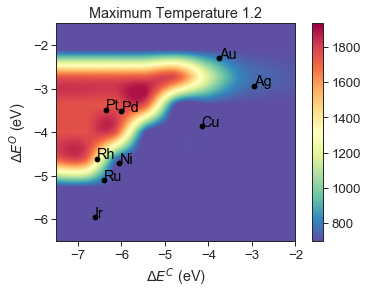

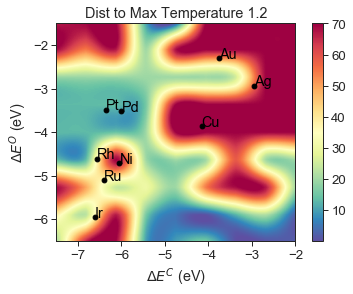

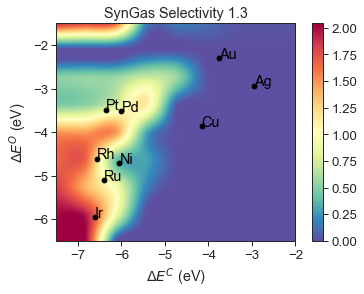

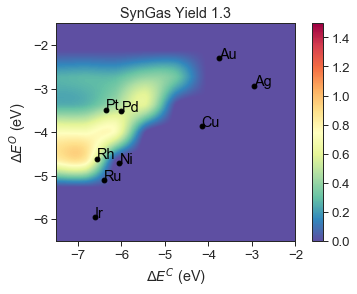

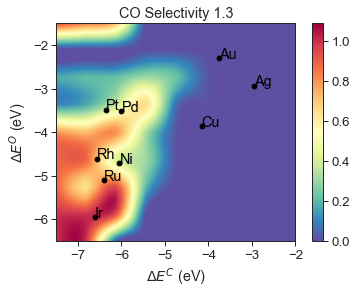

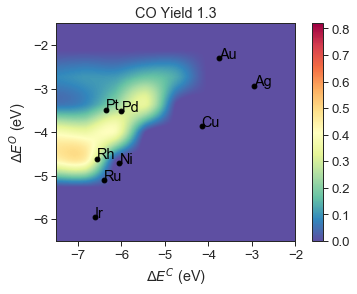

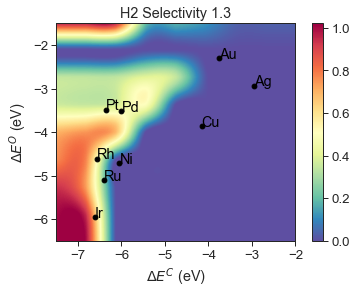

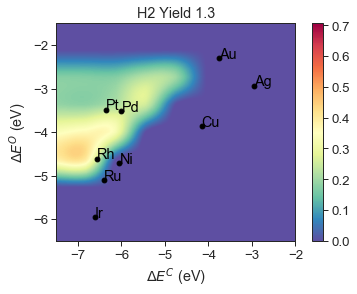

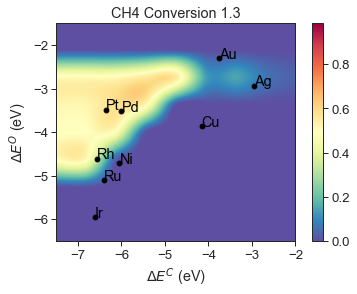

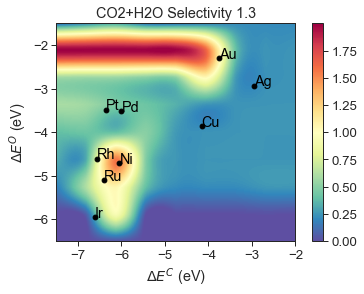

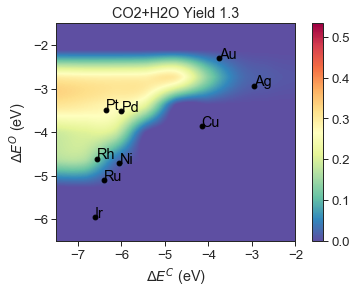

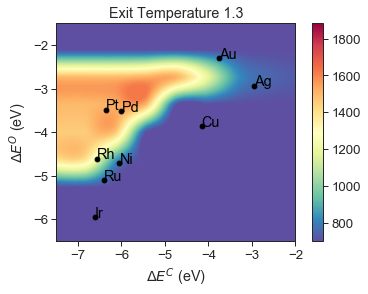

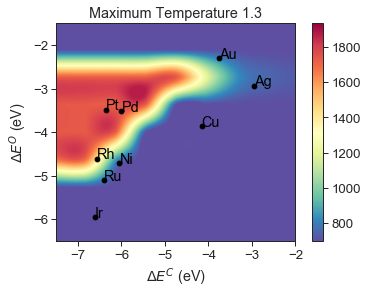

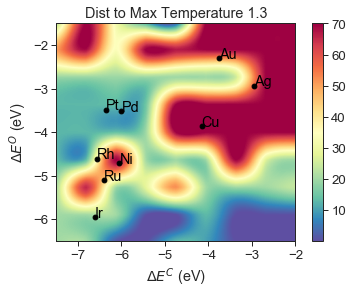

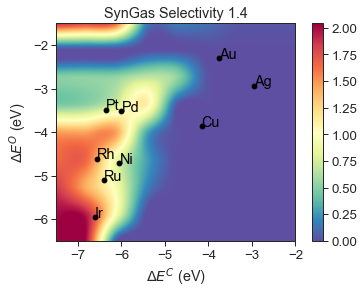

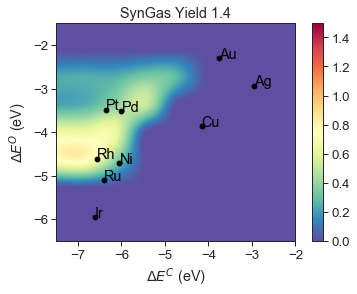

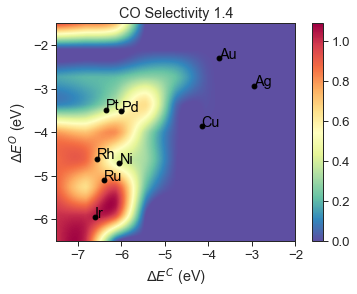

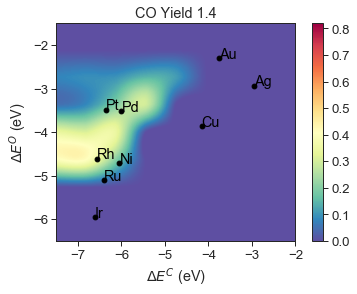

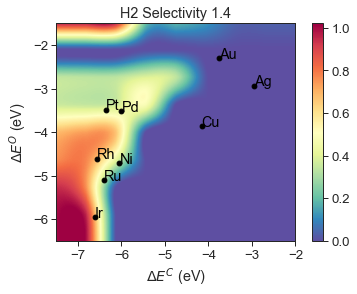

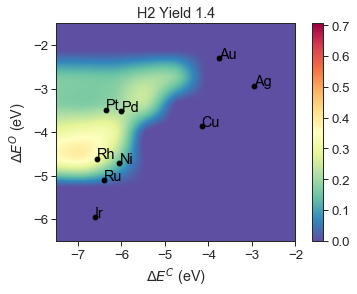

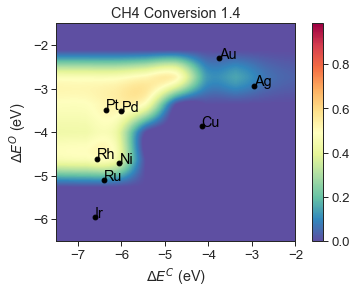

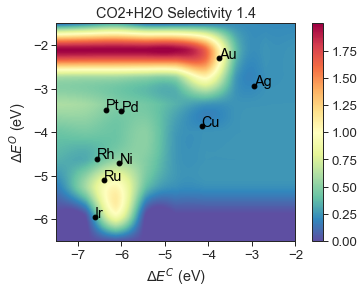

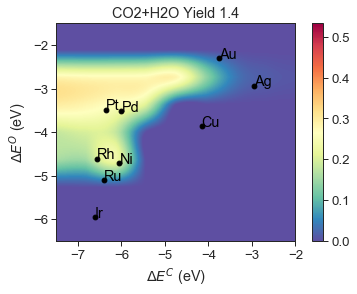

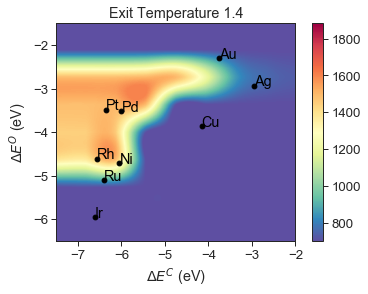

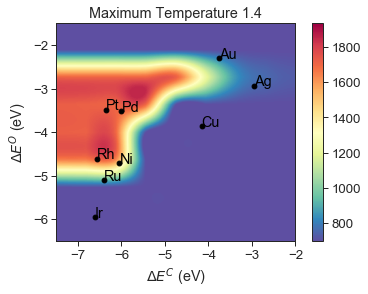

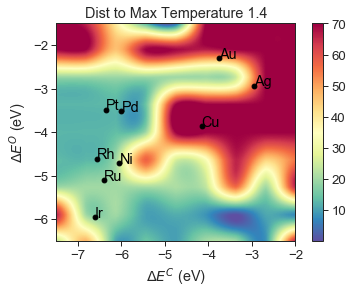

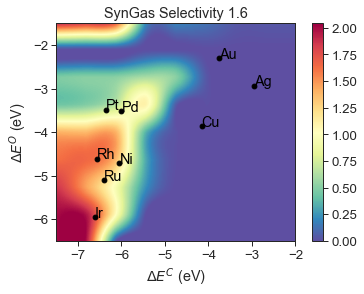

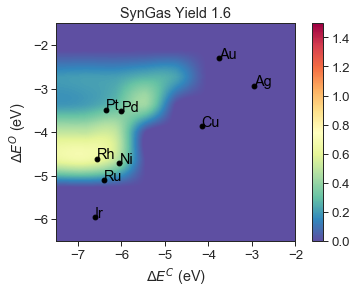

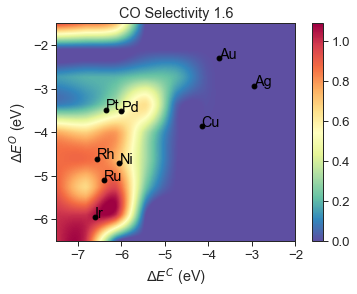

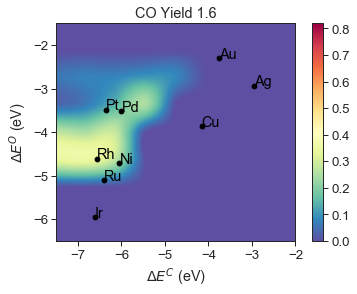

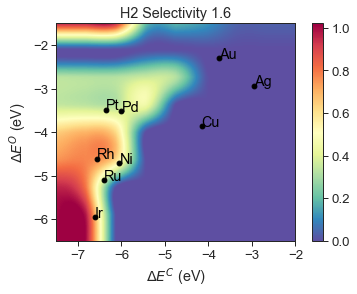

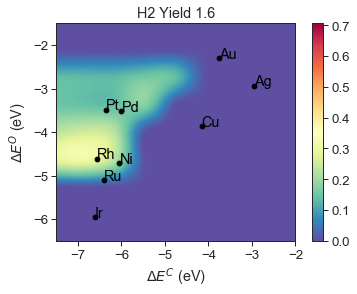

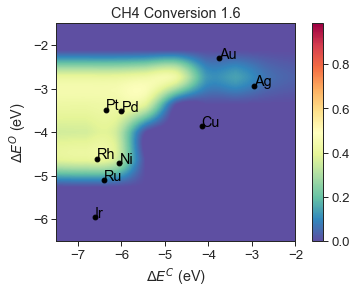

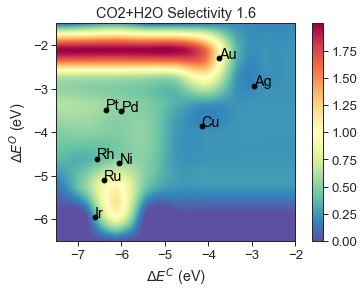

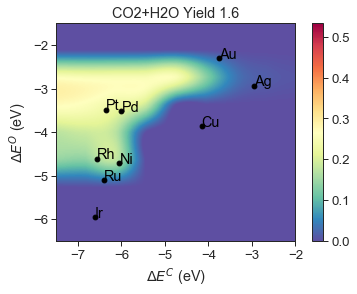

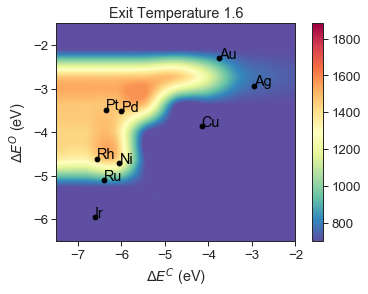

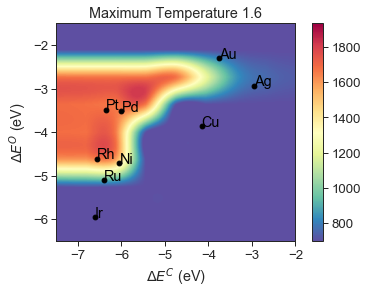

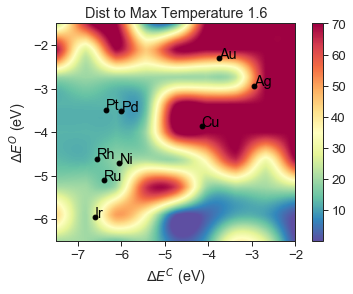

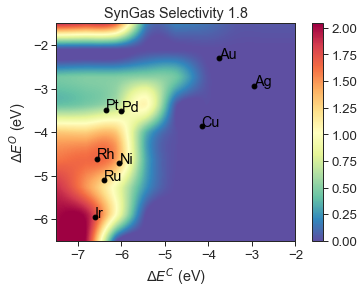

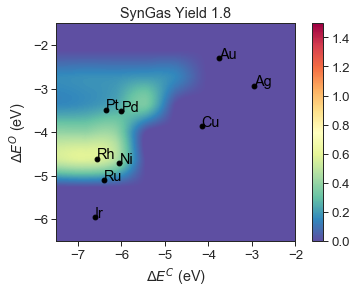

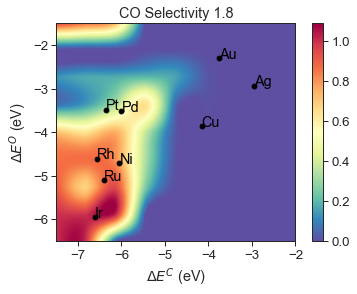

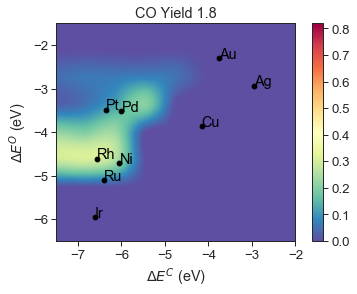

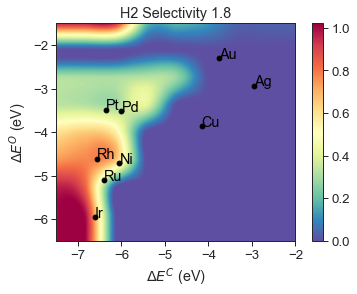

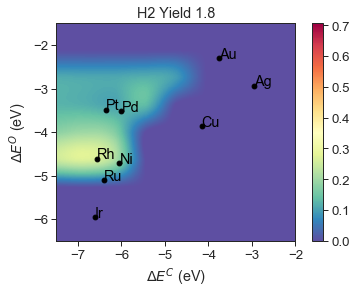

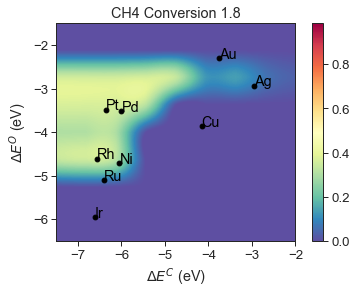

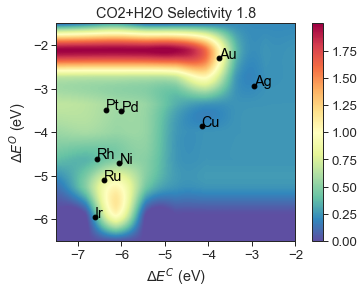

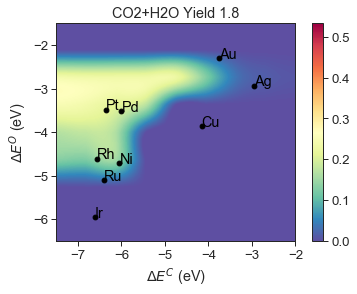

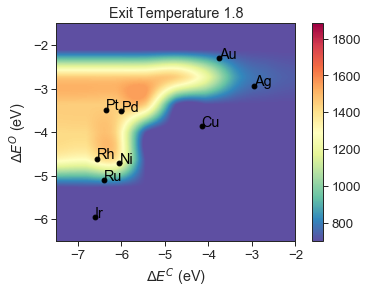

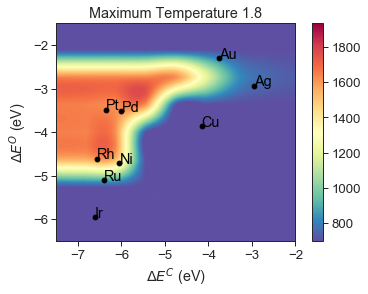

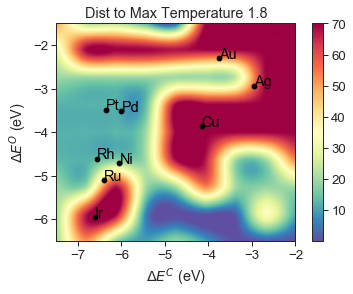

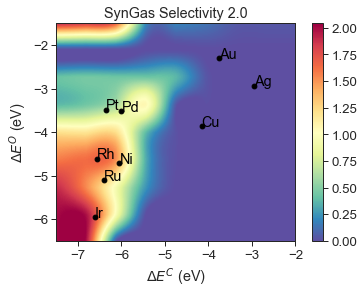

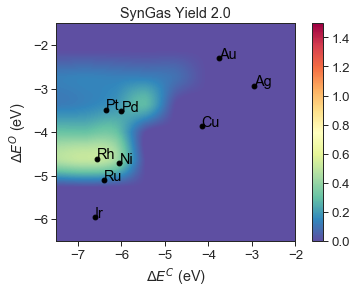

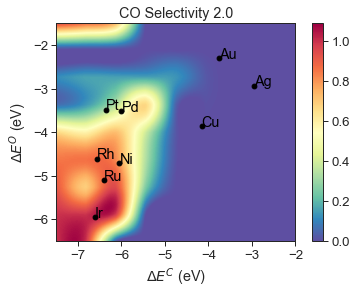

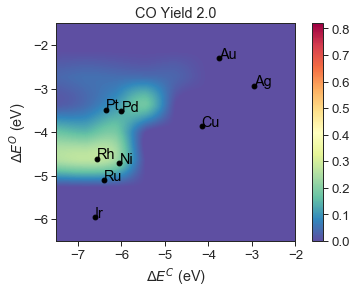

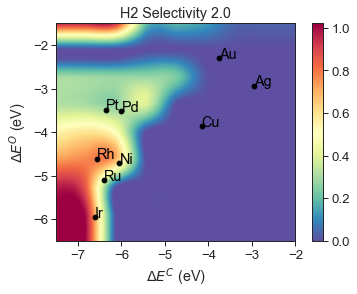

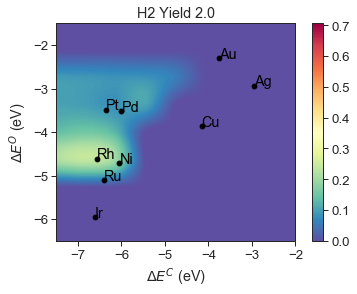

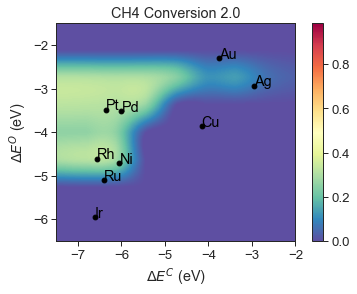

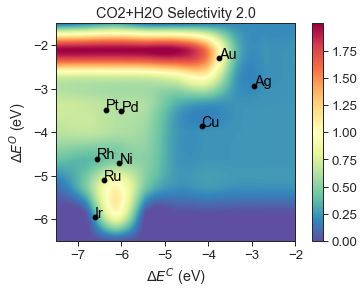

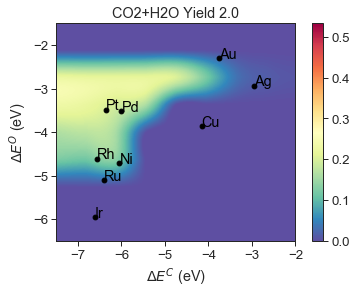

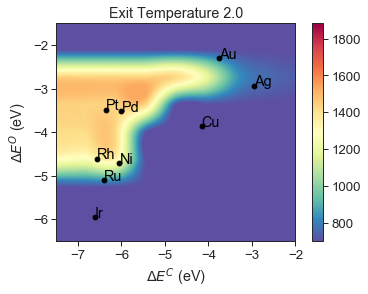

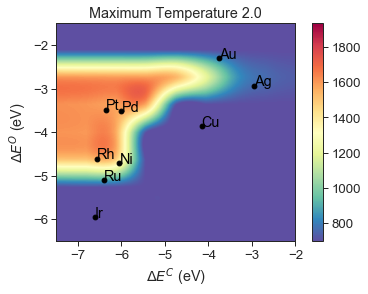

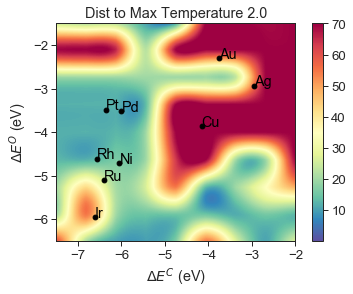

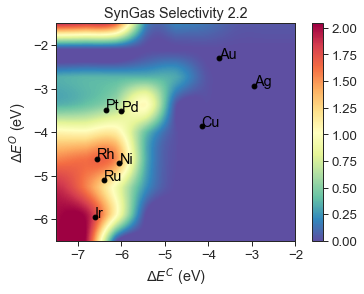

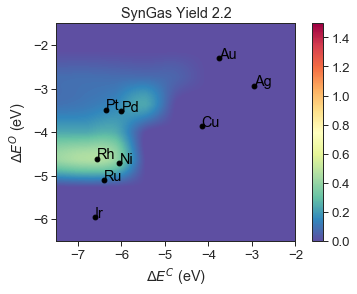

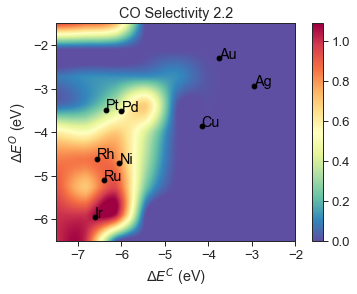

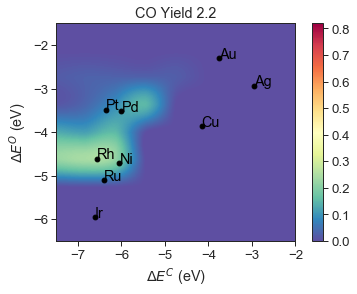

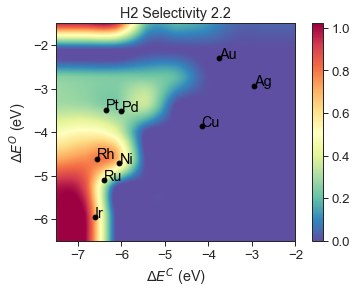

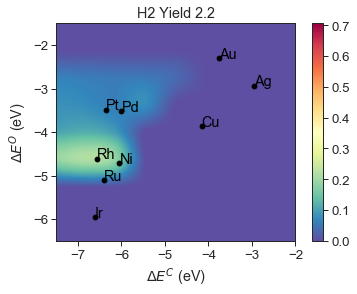

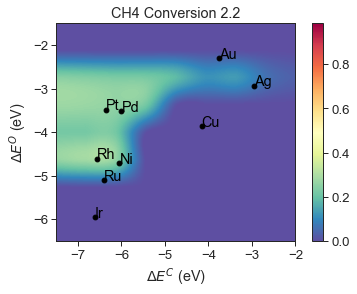

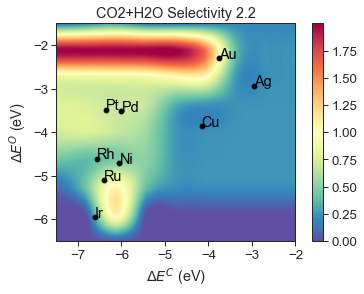

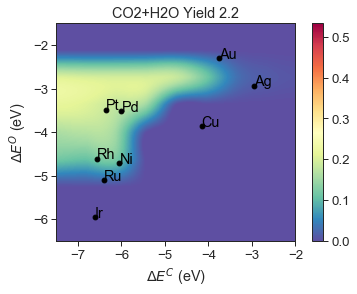

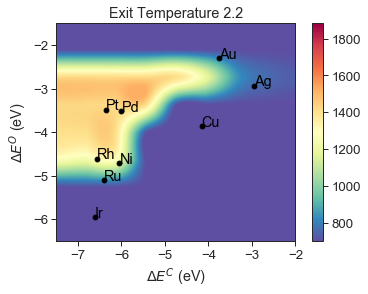

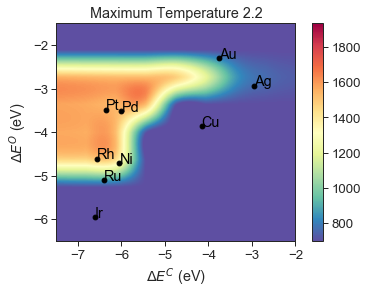

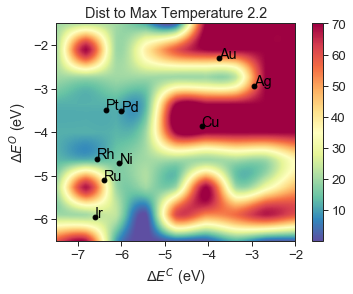

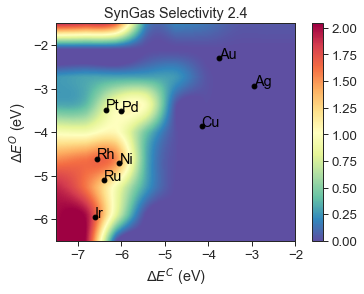

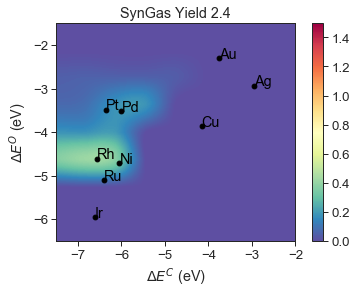

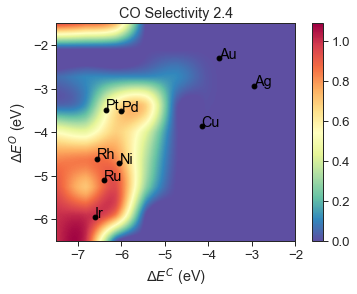

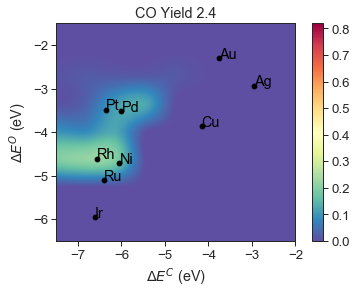

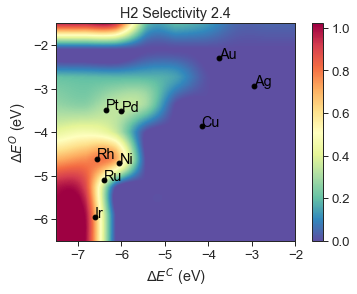

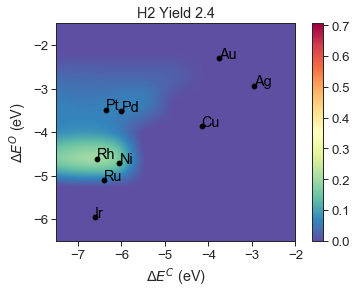

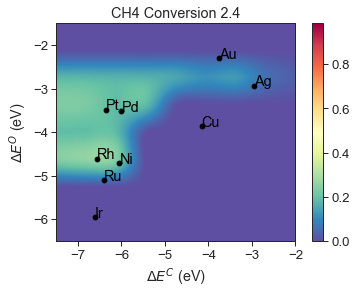

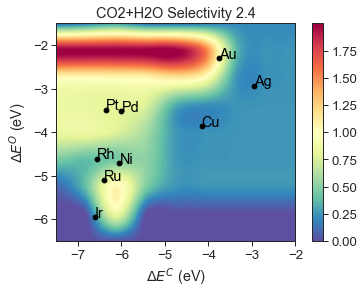

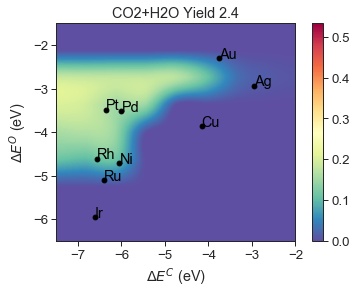

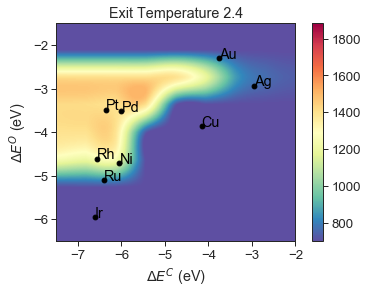

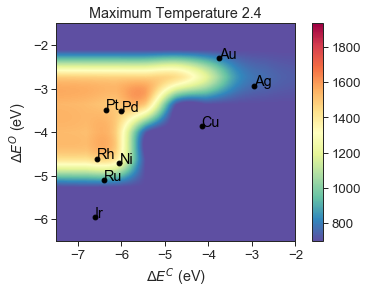

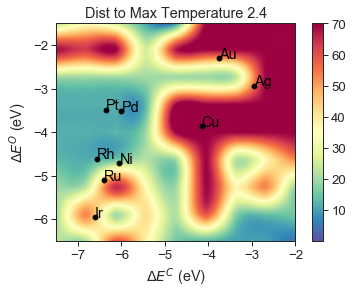

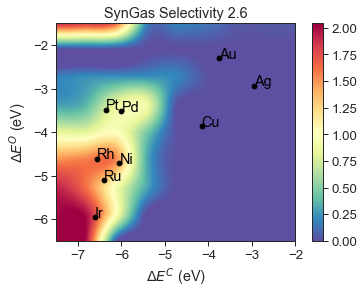

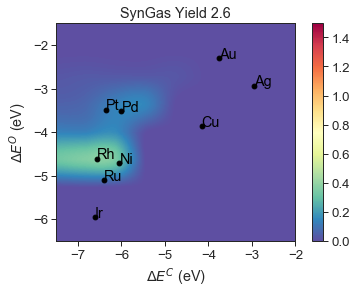

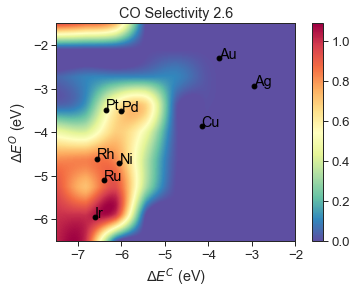

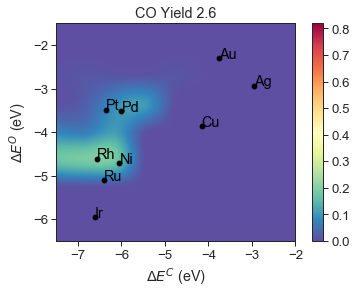

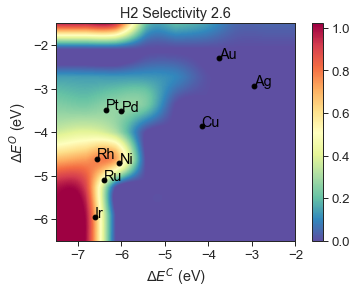

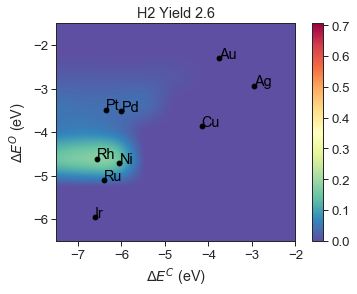

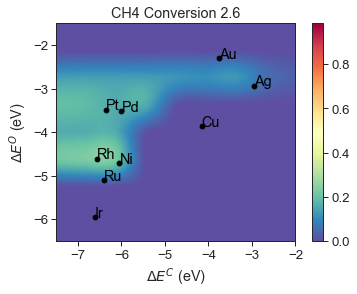

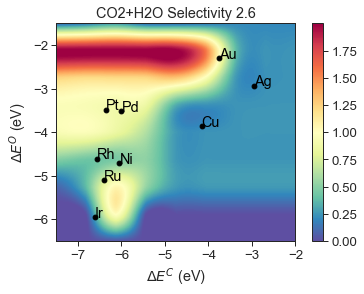

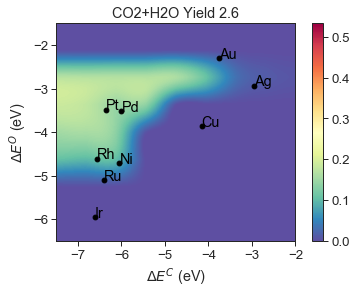

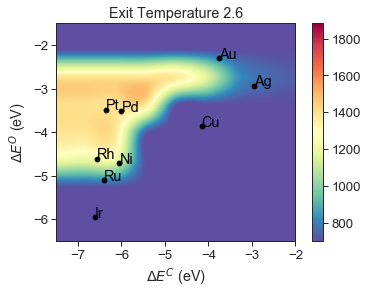

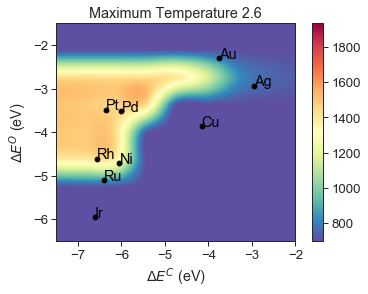

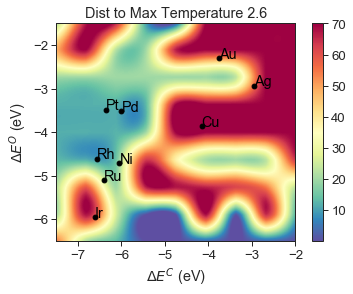

<Figure size 432x288 with 0 Axes>

In [605]:
# mkaing plots
for z in range(len(all_data)):
    ans = all_data[z]
    for s in range(len(ans[0])):
        data_to_plot = []
        for x in range(len(ans)):
            data_to_plot.append(ans[x][s])
        title = sens_types[s] + ' ' + str(ratios[z])
        lavaPlot(data_to_plot, title, axis=spans[s], folder='base')  # making plots

In [445]:
def import_sensitivities(ratio, file_location=False, thermo=False):
    """
    Ratio is the C/O starting gas ratio
    file_location is the LSR C and O binding energy, fasle to load the base case
    thermo is either False to load reaction sensitivities or True to load thermo sensitivities
    """
    try:
        # load in the sensitivity csv files
        if file_location is False:
            if thermo is False:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        else:
            if thermo is False:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        data = data.get_values()
        data = data.tolist()
        return data
    except:
        if thermo is False:
            print('Cannot find ' + str(ratio) + 'RxnSensitivity.csv for:    ' + file_location)
        else:
            print('Cannot find ' + str(ratio) + 'ThermoSensitivity.csv for: ' + file_location)
        # try loading the reactions from a different ratio to use as placeholders
        try_ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
        for r in try_ratios:
            try:
                if file_location is False:
                    if thermo is False:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                else:
                    if thermo is False:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                data = data.get_values()
                fakedata = data
#                 fakedata = np.zeros_like(data, dtype=float)
                for x in range(len(data)):
                    for y in xrange(2,14):
                        fakedata[x][y] = 0.0
                return fakedata.tolist()
                break
            except:
                continue

In [446]:
allrxndata = []  # where all rxn sens itivities will be stored
allthermodata = []  # where all thermo sensitivities will be stored
for f in array:
    rxndata = []
    thermodata = []
    for ratio in ratios:
        rxndata.append(import_sensitivities(ratio, file_location=f))
        thermodata.append(import_sensitivities(ratio, file_location=f, thermo=True))
    allrxndata.append(rxndata)
    allthermodata.append(thermodata)

Cannot find 0.9RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 1.4RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.0RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.2RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.4RxnSensitivity.csv for:    c-6.125o-1.500


In [447]:
num_surf_reactions = []
for x in array:
    gas = ct.Solution('./linearscaling/' + x + '/chem_annotated.cti', 'gas')
    surf = ct.Interface('./linearscaling/' + x + '/chem_annotated.cti', 'surface1', [gas])
    num_surf_reactions.append(surf.n_reactions)

# allrxndata[lsr BEs][c/o ratios][surface reactions][1=reaction, 2-14=sensitivities]

In [624]:
reactions = set()
for f in range(len(allrxndata)):
    for r in range(len(allrxndata[0][0])):
        reactions.add(allrxndata[f][0][r][1])
reactions = list(reactions)

for rxn in rxns_unique:  # for a certain reaction
    for s in xrange(2,14):  # sensitivity type
        all_sens = []
        for r in range(len(allrxndata[0])):  # for a single ratio
            sensitivities = []
#             title = rxn + ' '+ sens_types[s-2] + ' ' + str(ratios[r])
            got_value = False
            
            for f in range(len(array)):  # for lsr binding energies
                for p in range(len(allrxndata[f][r])):  # matching the reaction
                    if allrxndata[f][r][p][1] == np.str(rxn):
                        sensitivities.append(allrxndata[f][r][p][s])
                        got_value = True
                if got_value is False:  # put a placeholder in
                    sensitivities.append(0.)
            all_sens.append(sensitivities)
        
        # normalizing plots
        MAX = 0
        skip = None
        for x in xrange(15):
#             print all_sens[x]
            m = max(abs(np.array(all_sens[x])))
            print m
            if m > MAX:
                MAX = m
                
            if sum(abs(np.array(all_sens[x]))>1e-5) < 10:
                if skip is not False:
                    skip = True
            else:
                skip = False
            
#         if skip is True:
#             print "skipping {} {} because it's boring".format(rxn, sens_types[s-2])
#             continue
#         else:
#             for r in xrange(15):
#                 title = rxn + ' '+ sens_types[s-2] + ' ' + str(ratios[r])
#                 lavaPlot(all_sens[r], title, folder='rxnsensitivities', axis=[-1*MAX, MAX])

905.945299347
865.9192406330001
4708.70884664
320.496970773
83839.71103280001
2301.90015132
1341.15188025
181660.947933
129.365188649
122470.72718399999
154.010876626
3135.0635813999997
1154.99943091
955.5457529839999
1567.93520576
905.945299348
69501.8165151
639.819053382
531.347257791
83839.71103280001
99.9588401915
22870.557456799997
181660.947934
129.365188649
122470.72718399999
1568.7084347999998
3135.0635813999997
99.5583990658
955.5457529839999
1567.93520577
967.299503699
1423.10950963
7084507.54505
320.496961494
133103.119669
2301.90013099
1341.15165781
89702.4671948
129.11864637899998
60570.05534530001
13111.6023285
3402.85018109
2015.52910486
947.1341473269999
4110345.71993
967.299503701
109651.606721
147378.020318
1784.76462164
133103.119669
99.9735874703
11296.701888200001
89702.46719489999
129.11864637899998
60570.05534530001
951896.2771790001
3402.85018109
2015.52910486
1696.11435431
4110345.71993
869.7313088880001
673.997978973
4708.70863086
320.496970773
66128.988790199

KeyboardInterrupt: 

In [629]:
#test
rxn = rxns_unique[44]
print rxn
s = 3
print sens_types[s-2]

all_sens = []
for r in range(len(allrxndata[0])):  # for a single ratio
    sensitivities = []
#             title = rxn + ' '+ sens_types[s-2] + ' ' + str(ratios[r])
    got_value = False

    for f in range(len(array)):  # for lsr binding energies
        for p in range(len(allrxndata[f][r])):  # matching the reaction
            if allrxndata[f][r][p][1] == np.str(rxn):
                sensitivities.append(allrxndata[f][r][p][s])
                got_value = True
        if got_value is False:  # put a placeholder in
            sensitivities.append(0.)
    all_sens.append(sensitivities)

# all_sens length is 15 for each c/o raito
# normalizing plots
MAX = 0
skip = None
for x in xrange(15):
    print all_sens[x]
    m = max(abs(np.array(all_sens[x])))
    print m
#     if m > MAX:
#         MAX = m

#     if sum(abs(np.array(all_sens[x]))>1e-5) < 10:
#         if skip is not False:
#             skip = True
#     else:
#         skip = False

[Pt] + O=[Pt] <=> O[Pt] + [Pt]
SynGas Yield
[0.9381992965970001, 0.591487728591, -2.52880243633e-06, -1.09281906164e-05, -1.82871832728e-05, 0.000129285860359, -0.000383300485094, -5.06308673999e-05, -0.319342586352, 0.938109374447, 0.14993665716399998, -7.4166176132300005e-06, 1.7955208388500002e-09, 1.48382093937e-07, -0.0010196050048200001, -1.37421790897e-05, -2.15636021821e-10, 0.0487466270737, 0.913232355706, -0.0107980259989, -5.40640984786e-05, -2.2016374297200004e-09, -3.74600429395e-06, 2.06118652433e-05, 0.000547161407029, 0.0021237096416600004, -0.00100530221207, 0.514042139216, 0.14477773635, 0.000884143486893, 2.14219113292e-09, 1.7551530149599998e-06, -1.3334128487e-06, -0.00251844388792, -3.7403271147799994e-09, 11.6304197769, 0.352269701616, 0.28071491158399997, 0.806975166558, 2.7847257370599996e-08, 1.9534045192000001e-07, 7.04191487279e-06, -9.608753320200001e-05, 1.05171966704e-06, 69.1308182675, 0.276096496377, 0.282335960229, -0.009683230829910001, 1.28167916452e

In [639]:
g = 1.0e-8
h = 1e-8
print g,h
g==h

1e-08 1e-08


True

In [9]:
# Plot the number of surface reactions
# num_surf_reactions

# reaction_counts_grid = np.log10(np.reshape(num_surf_reactions, (grid_size,grid_size)))
# plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
# plt.xlim(carbon_range2)
# plt.ylim(oxygen_range2)
# plt.xlabel('$\Delta E^C$ (eV)')
# plt.ylabel('$\Delta E^O$ (eV)')
# for e,n in zip(experiments,num_surf_reactions):
#     plt.text(e[0],e[1],n,color='w',ha='center', va='center')
# plt.colorbar()

In [10]:
# A linear one, just to check it looks the same
# reaction_counts_grid = np.reshape(num_surf_reactions, (grid_size,grid_size))
# ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)